In [ ]:
# Установка необходимых библиотек
!pip install torch torchvision matplotlib tensorflow

# Импорт библиотек PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

# Импорт библиотек TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Импорт вспомогательных библиотек
import numpy as np
import matplotlib.pyplot as plt

# Настройка отображения графиков
%matplotlib inline

In [ ]:
!unzip -q /content/flowers.zip -d /content/flowers

In [ ]:
# Параметры
input_size = 128  # Размер входных изображений
num_classes = 5   # Количество классов
batch_size = 32
epochs = 20
learning_rate = 0.001

# Преобразования изображений (расширение набора данных)
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    RandomHorizontalFlip(),
    RandomRotation(15),
    ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor()
])

# Загрузка данных
root_dir = '/content/flowers/flowers'
dataset = ImageFolder(root=root_dir, transform=train_transforms)

In [ ]:
# Разделение на обучающую, валидационную и тестовую выборки
train_ratio = 0.8
temp_ratio = 0.5
n_total = len(dataset)
n_train = int(n_total * train_ratio)
n_temp = n_total - n_train
n_val = int(n_temp * temp_ratio)
n_test = n_temp - n_val

train_dataset, temp_dataset = random_split(dataset, [n_train, n_temp])
val_dataset, test_dataset = random_split(temp_dataset, [n_val, n_test])

# Изменяем трансформации для валидации и теста
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Определение модели
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (input_size // 8) * (input_size // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Инициализация модели, функции потерь и оптимизатора
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Функция обучения
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Обучение модели
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs)

# Тестирование модели
def test_model(model, test_loader):
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_correct += (outputs.argmax(1) == labels).sum().item()
    test_accuracy = test_correct / len(test_loader.dataset)
    print(f"Test Accuracy: {test_accuracy:.4f}")

test_model(model, test_loader)

Epoch [1/20] - Train Loss: 1.3310, Train Accuracy: 0.4315 - Val Loss: 1.1415, Val Accuracy: 0.5139
Epoch [2/20] - Train Loss: 1.1200, Train Accuracy: 0.5436 - Val Loss: 1.1400, Val Accuracy: 0.5532
Epoch [3/20] - Train Loss: 1.0327, Train Accuracy: 0.5899 - Val Loss: 0.9809, Val Accuracy: 0.6273
Epoch [4/20] - Train Loss: 0.9757, Train Accuracy: 0.6102 - Val Loss: 0.9386, Val Accuracy: 0.6250
Epoch [5/20] - Train Loss: 0.9323, Train Accuracy: 0.6435 - Val Loss: 0.9386, Val Accuracy: 0.6296
Epoch [6/20] - Train Loss: 0.8595, Train Accuracy: 0.6696 - Val Loss: 0.8857, Val Accuracy: 0.6528
Epoch [7/20] - Train Loss: 0.8305, Train Accuracy: 0.6791 - Val Loss: 0.8333, Val Accuracy: 0.6736
Epoch [8/20] - Train Loss: 0.7931, Train Accuracy: 0.6971 - Val Loss: 0.8328, Val Accuracy: 0.6829
Epoch [9/20] - Train Loss: 0.7663, Train Accuracy: 0.7075 - Val Loss: 0.7960, Val Accuracy: 0.6852
Epoch [10/20] - Train Loss: 0.7067, Train Accuracy: 0.7292 - Val Loss: 0.7945, Val Accuracy: 0.6898
Epoch [11

In [ ]:
root_dir = '/content/flowers/flowers'

# Создание датасета
full_dataset = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    label_mode='int',
    image_size=(128, 128),
    batch_size=32
)

# Сохраняем классы
class_names = full_dataset.class_names

# Оптимальное разбиение на выборки
dataset_size = full_dataset.cardinality().numpy()
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Функции предобработки
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_autoencoder(image, _):
    image = tf.cast(image, tf.float32) / 255.0
    return image, image

# Разбиение и оптимизация
dataset = full_dataset.map(preprocess_data).cache().shuffle(1000)
train_dataset = dataset.take(train_size)
val_test_dataset = dataset.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

train_autoencoder = train_dataset.map(lambda x, y: (data_augmentation(x), x))
train_autoencoder = train_autoencoder.map(preprocess_autoencoder)
val_autoencoder = val_dataset.map(preprocess_autoencoder)
test_autoencoder = test_dataset.map(preprocess_autoencoder)

train_autoencoder = train_autoencoder.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_autoencoder = val_autoencoder.cache().prefetch(tf.data.AUTOTUNE)
test_autoencoder = test_autoencoder.cache().prefetch(tf.data.AUTOTUNE)

train_classifier = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_classifier = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_classifier = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

Found 4317 files belonging to 5 classes.


In [ ]:
# Энкодер
input_shape = (128, 128, 3)
encoder_input = layers.Input(shape=input_shape)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoder_output = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

encoder = models.Model(encoder_input, encoder_output, name="encoder")

# Декодер
decoder_input = layers.Input(shape=(16, 16, 256))  # Указываем форму выхода энкодера
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = models.Model(decoder_input, decoder_output, name="decoder")

# Комбинированный автокодировщик
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder(encoder_input))
autoencoder = models.Model(autoencoder_input, autoencoder_output, name="autoencoder")

# Компиляция
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='mse', metrics=['accuracy'])

# Обучение автокодировщика
autoencoder.fit(train_autoencoder, validation_data=val_autoencoder, epochs=10)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.2529 - loss: 0.0731 - val_accuracy: 0.4284 - val_loss: 3.6406e-06
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.4468 - loss: 3.6562e-06 - val_accuracy: 0.4284 - val_loss: 3.6406e-06
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.4450 - loss: 3.6327e-06 - val_accuracy: 0.4284 - val_loss: 3.6406e-06
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.4528 - loss: 3.6265e-06 - val_accuracy: 0.4284 - val_loss: 3.6406e-06
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.4470 - loss: 3.6393e-06 - val_accuracy: 0.4284 - val_loss: 3.6406e-06
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.4403 - loss: 3.5877e-06 - val_accuracy: 0.4284 - val_loss: 3.6406e-06
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.4327 - loss: 3.5929e-06 - val_accuracy: 0.4284 - val_loss: 3.6406e-06
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 151s 

In [ ]:
# Разморозка слоев энкодера
for layer in encoder.layers:
    layer.trainable = False

# Модель классификации с улучшениями
classifier = models.Sequential([
    encoder,  # Замороженный энкодер
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Компиляция классификатора
classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Обучение классификатора
history_classifier = classifier.fit(
    train_classifier,
    epochs=10,
    validation_data=val_classifier,
    callbacks=[early_stopping, reduce_lr]
)

# Тестирование
test_loss, test_acc = classifier.evaluate(test_classifier)
print(f"Test Accuracy: {test_acc:.2f}")


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 215ms/step - accuracy: 0.3457 - loss: 2.1176 - val_accuracy: 0.2188 - val_loss: 1.7416 - learning_rate: 5.0000e-04
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.5679 - loss: 1.3536 - val_accuracy: 0.2404 - val_loss: 1.6932 - learning_rate: 5.0000e-04
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.5776 - loss: 1.2950 - val_accuracy: 0.2885 - val_loss: 1.5241 - learning_rate: 5.0000e-04
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - accuracy: 0.6274 - loss: 1.1606 - val_accuracy: 0.4736 - val_loss: 1.3104 - learning_rate: 5.0000e-04
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 38s 198ms/step - accuracy: 0.6102 - loss: 1.1782 - val_accuracy: 0.6418 - val_loss: 1.0651 - learning_rate: 5.0000e-04
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 209ms/step - accuracy: 0.6217 - loss: 1.1375 - val_accuracy: 0.6827 - val_loss: 0.9467 - learning_rate: 5.0000e-04
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 20

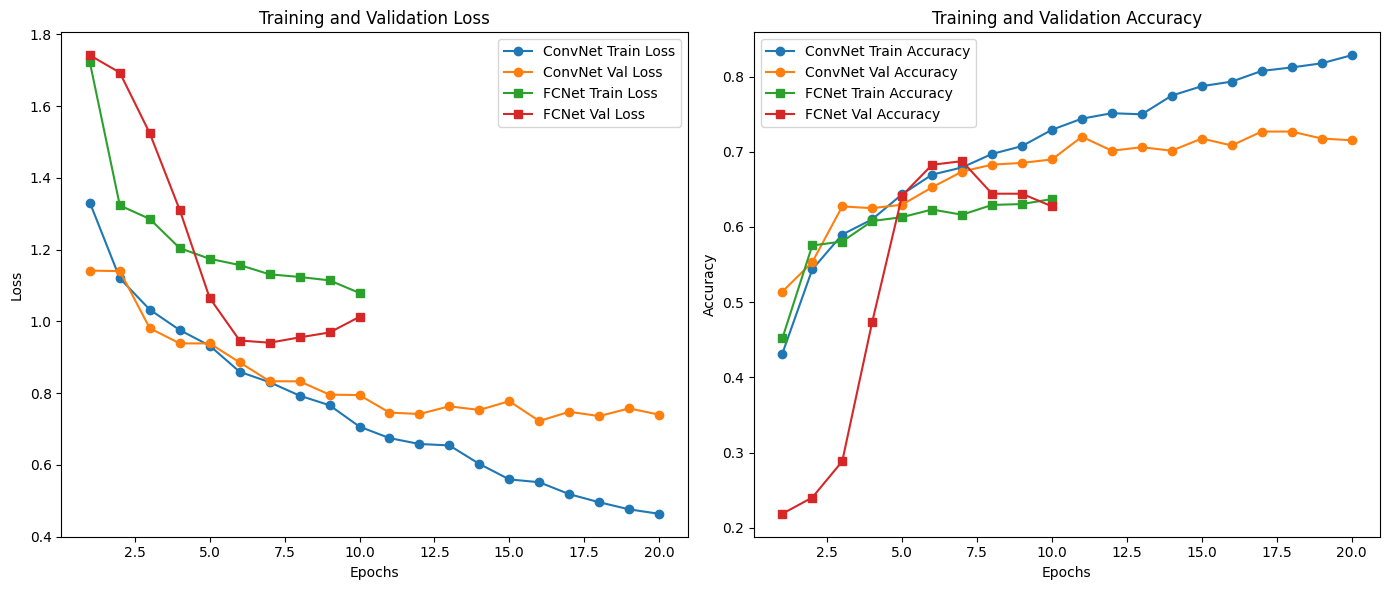

In [ ]:
# Данные для ConvNet
epochs_conv = range(1, len(train_losses) + 1)
conv_train_losses = train_losses
conv_val_losses = val_losses
conv_train_accuracies = train_accuracies
conv_val_accuracies = val_accuracies

# Данные для FCNet (из Keras)
fc_train_losses = history_classifier.history['loss']
fc_val_losses = history_classifier.history['val_loss']
fc_train_accuracies = history_classifier.history['accuracy']
fc_val_accuracies = history_classifier.history['val_accuracy']
epochs_fc = range(1, len(fc_train_losses) + 1)

# Построение графиков
plt.figure(figsize=(14, 6))

# Графики потерь
plt.subplot(1, 2, 1)
plt.plot(epochs_conv, conv_train_losses, label='ConvNet Train Loss', marker='o')
plt.plot(epochs_conv, conv_val_losses, label='ConvNet Val Loss', marker='o')
plt.plot(epochs_fc, fc_train_losses, label='FCNet Train Loss', marker='s')
plt.plot(epochs_fc, fc_val_losses, label='FCNet Val Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Графики точности
plt.subplot(1, 2, 2)
plt.plot(epochs_conv, conv_train_accuracies, label='ConvNet Train Accuracy', marker='o')
plt.plot(epochs_conv, conv_val_accuracies, label='ConvNet Val Accuracy', marker='o')
plt.plot(epochs_fc, fc_train_accuracies, label='FCNet Train Accuracy', marker='s')
plt.plot(epochs_fc, fc_val_accuracies, label='FCNet Val Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
